# Exploratory NLP Project – Media Framing and Public Preferences in Swiss Referenda

## Introduction

This project explores the extent to which media coverage in Switzerland reflects the political preferences of the voting population in the context of direct democratic referenda. Specifically, we examine whether the tone and thematic content of newspaper articles published before popular votes are aligned with the eventual outcomes of those referenda. Rather than testing for causal influence, the aim is to investigate whether news media can serve as a proxy or indicator of prevailing public sentiment. The approach is exploratory in nature, given the limited sample size and the challenges of modeling opinion formation processes with textual data.

Over the past two decades, Switzerland has held a large number of referenda on a wide range of political issues. For this study, we randomly selected twenty initiatives from the past twenty years. For each initiative, we gathered a set of articles from three major Swiss media outlets: *Neue Zürcher Zeitung (NZZ)*, *Schweizer Radio und Fernsehen (SRF)*, and *20 Minuten*. All articles were chosen based on their publication date prior to the actual vote and selected at random from relevant search results. The resulting dataset consists of approximately 113 articles. Although data collection was partially manual, the extraction of text from article URLs and the removal of non-relevant content (e.g., navigation bars, ads) is similar in spirit to standard web scraping techniques.

Given the relatively small dataset, the analysis relies mainly on pre-trained language models. These models allow us to apply advanced Natural Language Processing (NLP) techniques without requiring training data of our own. The project proceeds in three analytical steps that build upon one another.

In Step 1, we focus on data retrieval and management. This involves collecting, extracting, and cleaning textual data from selected media articles. Each article is obtained from a verified URL, with the raw HTML parsed and stripped of irrelevant elements such as navigation bars, advertisements, or comment sections. The remaining content is cleaned and stored in structured form, mapped to one of twenty selected Swiss popular initiatives and labeled according to the final vote outcome. The resulting corpus includes around 100 to 120 articles from NZZ, SRF, and 20 Minuten, each published prior to the respective referendum.

Step 2 consists of descriptive analysis and visualization. This part of the project aims to provide an initial overview of the dataset, both in terms of structure and content. We examine the distribution of articles across initiatives and outlets, analyze the length of individual texts, and conduct a word frequency analysis to uncover which terms appear more frequently in association with initiatives that were ultimately accepted versus those that were rejected. Word clouds and other visual tools are used to summarize these patterns and highlight salient terms that may hint at recurring frames or emphasis in the reporting.

In Step 3, we move to thematic and sentiment modeling. Thematic content is identified using a zero-shot classification approach based on the `facebook/bart-large-mnli` model, allowing us to assign high-level topic labels to each article without supervised training. This enables us to explore whether the thematic framing of initiatives systematically differs between accepted and rejected cases. In parallel, sentiment analysis is conducted using pre-trained transformer models, with the goal of determining whether the emotional tone of reporting—positive, negative, or neutral—shows consistent alignment or divergence with the public vote. 

Finally, as a proof of concept, we explore the possibility of predicting referendum outcomes based on article content. Using basic supervised machine learning models such as logistic regression, we attempt to classify initiatives as accepted or rejected based on textual features. This step is not intended to yield reliable predictions but rather to test whether the text corpus contains predictive signals that reflect alignment between media discourse and public sentiment.


The project is limited by several factors (discussed in each step). Most importantly, the small sample size restricts the statistical power of the analysis and precludes the training of custom models. Moreover, all insights are constrained by the fact that the underlying models were trained on general-purpose, non-Swiss corpora. Nevertheless, we believe that the approach taken here offers a valuable exploratory perspective on the interplay between media and public opinion in a direct democracy and may provide a foundation for future research using larger and more representative datasets.


---

## 1. Data Retrieval and Management

Before starting the analysis, we install and import all necessary Python libraries for text preprocessing, sentiment analysis, topic modeling, and visualization.

In [2]:
# install required packages (pandas, requests, beautifulsoup4, tqdm, wordcloud, spacey, openpyxl, seaborn, nltk) if not already installed
# import core libraries
import pandas as pd
import numpy as np
import re
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm

# spaCy for tokenization, lemmatization, and compound splitting
import spacy
from split_words import Splitter

# scikit-learn for traditional feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Transformers for BERT embeddings
from transformers import AutoTokenizer, AutoModel



c:\Users\Giou1\anaconda3\envs\textmining\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [14]:
# load data
input_path = "Data_ML.xlsx" 
df = pd.read_excel(input_path)

In [15]:
# inspect data
df.head()

,vote_id,id,voting_date,initiative,yes_share,result,news_article_URL,publication_date,newspaper_name,text
0,1,1,2011-02-13,Für den Schutz vor Waffengewalt,0.437,Abgelehnt,https://www.20min.ch/story/tell-srebrenica-und-das-hoechste-us-gericht-475305857102,2011-01-09,20min,NaN
1,1,2,2011-02-13,Für den Schutz vor Waffengewalt,0.437,Abgelehnt,https://www.20min.ch/story/abstimmung-mit-promi-faktor-183387352487,2011-02-08,20min,NaN
2,1,3,2011-02-13,Für den Schutz vor Waffengewalt,0.437,Abgelehnt,https://www.20min.ch/story/daempfer-fuer-schutz-vor-waffengewalt-497838875267,2011-01-04,20min,NaN
3,1,4,2011-02-13,Für den Schutz vor Waffengewalt,0.437,Abgelehnt,https://www.20min.ch/story/kommission-lehnt-waffen-initiative-ab-607554392815,2011-01-04,20min,NaN
4,1,5,2011-02-13,Für den Schutz vor Waffengewalt,0.437,Abgelehnt,https://www.20min.ch/story/waffenlobby-wittert-unheil-105896974979,2011-01-13,20min,NaN


Based on a comprehensive list of Swiss national initiatives, we randomly selected 20 initiatives from the past 20 years, covering nearly 80% of all referenda in this domain during that time. Using a combination of manual selection and AI-assisted search, we compiled a set of relevant news articles from three major Swiss outlets: SRF, NZZ, and 20 Minuten. All articles were *published prior to the respective votes*. Since NZZ articles require login credentials and are not publicly accessible, their texts were manually copied and added to the dataset. For SRF and 20 Minuten, automated scraping was feasible.

Below, we define a custom scraping function that takes a URL and extracts the article content. It uses the `requests` library to access the page and `BeautifulSoup` to parse the HTML. The function retrieves all visible paragraph tags (`<p>`) and concatenates them into a single text string. We then apply this function only to articles from SRF and 20 Minuten, for which no text has yet been collected. The results are saved in the *text* column and exported to a filled Excel file.


In [16]:
# Function to scrape URL and extract text
def extract_text_from_url(url):
    try:
        headers = {
            "User-Agent": "Mozilla/5.0"
        }
        response = requests.get(url, headers=headers, timeout=10)
        if response.status_code != 200:
            return None
        soup = BeautifulSoup(response.content, "html.parser")
        paragraphs = soup.find_all("p")
        text = " ".join(p.get_text().strip() for p in paragraphs)
        return text if text else None
    except Exception as e:
        print(f"Fehler bei URL: {url} → {e}")
        return None

# Filter: only Articles NOT from nzz 
df_scrape = df[
    (~df["newspaper_name"].str.lower().str.contains("nzz", na=False)) &
    (~df["news_article_URL"].isnull()) &
    (df["text"].isnull() | (df["text"].str.strip() == ""))
]

# start scraping and add to existing 'text'-variable
for idx in tqdm(df_scrape.index):
    url = df.at[idx, "news_article_URL"]
    text = extract_text_from_url(url)
    df.at[idx, "text"] = text

# create new file with filled text variable 
output_path = "Data_ML_filled.xlsx"
df.to_excel(output_path, index=False)
print(f" Done, saved as: {output_path}")





100%|██████████| 76/76 [00:30<00:00,  2.47it/s]

 Done, saved as: Data_ML_filled.xlsx


Load the new dataset for following analysis and inspect the texts to find re-occuring wording and phrases not related to the article

In [4]:
# load new data
input_path = "Data_ML_filled.xlsx" 
df_new = pd.read_excel(input_path)


In [5]:
# check number of NaN values in the text column
print(f"Number of NaN values in 'text' column: {df_new['text'].isnull().sum()}")

# find out which rows have NaN in the 'text' column
nan_rows = df_new[df_new["text"].isnull()]
print("Rows with NaN in 'text' column:")
print(nan_rows[['initiative', 'news_article_URL']])

# show 5 random articles with text longer than 50 characters
df_sample = df_new[df_new["text"].notnull() & (df_new["text"].str.len() > 50)].sample(5, random_state=1)

# print the sample articles
pd.set_option('display.max_colwidth', None)
df_sample[["newspaper_name", "news_article_URL", "text"]]



Number of NaN values in 'text' column: 4
Rows with NaN in 'text' column:
                                           initiative  \
0                     Für den Schutz vor Waffengewalt   
4                     Für den Schutz vor Waffengewalt   
11                           Gegen Masseneinwanderung   
23  Millionen-Erbschaften besteuern für unsere AHV...   

                                     news_article_URL  
0   https://www.20min.ch/story/tell-srebrenica-und...  
4   https://www.20min.ch/story/waffenlobby-wittert...  
11  https://www.20min.ch/story/alle-anderen-partei...  
23  https://www.20min.ch/story/gegner-sehen-unnoet...  


newspaper_name  \
104          20min   
94           20min   
96             srf   
93             nzz   
105          20min   

                                                                                                                              news_article_URL  \
104                                https://www.20min.ch/story/abstimmung-darum-warnt-der-bundesrat-vor-der-biodiversitaetsinitiative-103171217   
94                                                   https://www.20min.ch/story/13-ahv-rente-linke-eroeffnen-den-abstimmungskampf-557637387047   
96   https://www.srf.ch/sendungen/kassensturz-espresso/kassensturz/abstimmung-am-3-maerz-2024-die-13-ahv-rente-sorgt-fuer-hitzige-diskussionen   
93                                         https://www.nzz.ch/schweiz/13-ahv-rente-die-linke-mobilisiert-gezielt-frauen-fuer-ein-ja-ld.1814584   
105                    https://www.20min.ch/story/chunsch-drus-darum-gehts-deshalb-spaltet-die-biodiversitaets-abstimmung-die-bauern-103167786   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

Upon closer inspection of the raw article texts, we identified systematic non-content elements in both SRF and 20 Minuten articles. These include login instructions, app banners, author lines, and embedded lists of unrelated games or features that frequently appear at the beginning or end of the articles. As these components are not part of the actual journalistic content, we exclude them from the dataset in the following step using tailored cleaning functions for each news outlet.


In [6]:
# Clean SRF articles by removing known junk phrases and footer blocks
def clean_srf_text(text):
    if not isinstance(text, str):
        return text

    # 1. Remove known static junk phrases
    garbage_phrases = [
        "Einige Elemente auf SRF.ch funktionieren nur mit aktiviertem JavaScript",
        "SRF News App Bei Google Play",
        "In der App öffnen", 
        "Wenn Sie sich erneut für die Kommentarfunktion registrieren möchten, melden Sie sich bitte beim Kundendienst von SRF.",
        "SRF Schweizer Radio und Fernsehen,Zweigniederlassung der Schweizerischen Radio- und Fernsehgesellschaft"

    ]
    for phrase in garbage_phrases:
        if phrase in text:
            text = text.replace(phrase, "")

    # 2. Remove dynamic noisy patterns (author info, footer, etc.)
    text = re.sub(r"Autor:\s*\n?.*?\d{2}\.\d{2}\.\d{4}, \d{2}:\d{2}", "", text)
    text = re.sub(r"Für die Registrierung benötigen wir.*", "", text)
    text = re.sub(r"Bitte melden Sie sich an, um einen Kommentar zu erfassen.*", "", text)


    return text.strip()


# Apply SRF cleaning to all SRF articles
mask_srf = df_new["newspaper_name"].str.lower().str.contains("srf", na=False)
df_new.loc[mask_srf, "text"] = df_new.loc[mask_srf, "text"].apply(clean_srf_text)


# Clean 20min articles by removing game lists and footer elements
def clean_20min_text(text):
    if not isinstance(text, str):
        return text
    
    garbage_words_20min = [
    "Deine Meinung zählt", "Solitaire", "Kreuzworträtsel", "Sudoku", "Mahjong", "Bubbles",
    "Snake", "Schach", "eXchange", "Power of 2", "Doppel", "Cuboro", "Riddles", "Wortblitz",
    "SudoKen", "Street", "Fibonacci", "Gumblast", "Rushtower", "Skiracer", "Wimmlbid", "(sda)"
]
    
    for phrase in garbage_words_20min:
        text = text.replace(phrase, "")

    return text.strip()

# Apply 20min cleaning to all 20 Minuten articles
mask_20min = df_new["newspaper_name"].str.lower().str.contains("20", na=False)
df_new.loc[mask_20min, "text"] = df_new.loc[mask_20min, "text"].apply(clean_20min_text)


## final clean: remove NaN values from the text column
df_new = df_new[df_new["text"].notnull() & (df_new["text"].str.strip() != "")]



Print random articles form 20min and SRF to insepct if there are still some remaining non-content elements.

In [7]:
# Show 5 random cleaned SRF and 5 random 20min articles
sample_srf = df_new[mask_srf & df_new["text"].notnull() & (df_new["text"].str.len() > 100)].sample(5, random_state=1)
sample_20min = df_new[mask_20min & df_new["text"].notnull() & (df_new["text"].str.len() > 100)].sample(5, random_state=2)

display(sample_srf[["newspaper_name", "news_article_URL", "text"]])
display(sample_20min[["newspaper_name", "news_article_URL", "text"]])

C:\Users\Giou1\AppData\Local\Temp\ipykernel_28628\2854373692.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sample_srf = df_new[mask_srf & df_new["text"].notnull() & (df_new["text"].str.len() > 100)].sample(5, random_state=1)
C:\Users\Giou1\AppData\Local\Temp\ipykernel_28628\2854373692.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sample_20min = df_new[mask_20min & df_new["text"].notnull() & (df_new["text"].str.len() > 100)].sample(5, random_state=2)


newspaper_name  \
14            srf   
83            srf   
15            srf   
66            srf   
79            srf   

                                                                                                   news_article_URL  \
14  https://www.srf.ch/news/schweiz/masseneinwanderungs-initiative-die-auslaender-kommen-die-schweiz-unter-zugzwang   
83               https://www.srf.ch/radio-srf-1/abstimmung-am-13-februar-tierversuchsverbotsinitiative-ja-oder-nein   
15   https://www.srf.ch/news/schweiz/paedophilen-initiative-paedophile-sollen-nie-mehr-mit-kindern-arbeiten-duerfen   
66                  https://www.srf.ch/news/abstimmung-von-26-september-99-prozent-initiative-spaltet-die-meinungen   
79                  https://www.srf.ch/radio-srf-1/justizinitiative-richterwahl-im-losverfahren-die-bessere-loesung   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

newspaper_name  \
42          20min   
43          20min   
88          20min   
30          20min   
94          20min   

                                                                                                    news_article_URL  \
42                              https://www.20min.ch/story/bundesrat-lehnt-die-begrenzungsinitiative-ab-983134565504   
43                     https://www.20min.ch/story/was-geschieht-wenn-die-svp-initiative-angenommen-wird-433791918637   
88  https://www.20min.ch/story/das-musst-du-zur-initiative-fuer-ein-verbot-der-massentierhaltung-wissen-177410670324   
30                           https://www.20min.ch/story/der-bestatter-greift-in-die-billag-schlacht-ein-191657448417   
94                         https://www.20min.ch/story/13-ahv-rente-linke-eroeffnen-den-abstimmungskampf-557637387047   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

```markdown
Next we will clean the data so that it can better be used for statistical analysis.


## Text Preprocessing Function: `preprocess_text`

This function takes a raw German text input and returns a fully cleaned, tokenized, compound-split, stop-word filtered and lemmatized string. It implements best practices for preparing a corpus for classical ML models (e.g. TF-IDF) or modern embeddings (e.g. BERT).

1. **Force string & lowercase**  
   - Ensures every input is treated as text (no floats / NaNs).  
   - Lowercases to collapse “Haus” and “haus” into the same token.

2. **Remove URLs, digits & unwanted punctuation**  
   - URLs and numbers rarely carry semantic weight in political or news analysis.  
   - We strip all characters except letters, spaces and German umlauts/ß to simplify downstream tokenization.

3. **Tokenization & stop-word filtering**  
   - spaCy splits the cleaned string into tokens.  
   - Tokens marked as stop-words (e.g. “und”, “der”) or non-alphabetical are discarded to focus on content words.

4. **Compound splitting**  
   - German compounding (“Militärwaffen”) creates very long tokens, leading to data sparsity.  
   - We use a compound splitter to break each token into its meaningful parts (→ “Militär”, “Waffen”).

5. **Lemmatization**  
   - Each split piece is fed back into spaCy to obtain its lemma (dictionary form).  
   - Lemmas of length ≤2 are discarded to remove noise (e.g. “im”, “am”).

6. **Re-join tokens**  
   - The final output is a space-joined string of clean, meaningful lemmas ready for vectorization.

**Why this matters**  
- **Data quality**: eliminates noise (junk characters, filler words).  
- **Vocabulary control**: splits compounds and lemmatizes to reduce the total number of unique tokens.  
- **Model performance**: cleaner, more consistent inputs improve both statistical models (TF-IDF, bag-of-words) and neural embeddings (BERT).  


In [13]:
import re
import spacy
from split_words import Splitter  # or whichever splitter you chose

# Initialize once
nlp     = spacy.load("de_core_news_sm", disable=["parser", "ner"])
splitter = Splitter()

def preprocess_text(text) -> str:
    # 0) Force string
    text = "" if text is None else str(text)

    # 1) Generic cleaning
    text = text.lower()
    text = re.sub(r"http\S+|www\.\S+", "", text)     # remove URLs
    text = re.sub(r"\d+", "", text)                  # remove digits
    text = re.sub(r"[^\w\säöüß]", " ", text)         # keep letters + umlauts only
    text = re.sub(r"\s+", " ", text).strip()         # collapse spaces

    # 2) Tokenization & stop-word filtering
    doc = nlp(text)
    tokens = []
    for token in doc:
        if not token.is_alpha or token.is_stop:
            continue

        # 3) Compound splitting
        raw_parts = splitter.split_compound(token.text)
        # flatten and ensure strings
        parts = []
        for pair in raw_parts:
            for p in pair:
                parts.append(str(p))

        # 4) Lemmatization
        for part in parts:
            part_doc = nlp(part)
            lemma = part_doc[0].lemma_
            if len(lemma) > 2:
                tokens.append(lemma)

    # 5) Return as one space-joined string
    return " ".join(tokens)

# Apply to your DataFrame
df_new["clean_text"] = df_new["text"].apply(preprocess_text)


check the result

In [15]:
for raw, clean in df_new[["text", "clean_text"]].sample(5).values:
    print("RAW:", raw[:100], "…")
    print("CLEAN:", clean, "\n")

RAW: . Heute werden die Richterinnen und Richter für das Bundesgericht vom Parlament gewählt. Die Justizi …
CLEAN: 0.7975929167477054 Richter innen 0.34248213576816194 Richt Rinn -0.833087329110659 Richt Erinn -1.091282023850228 rich Terinn -1.2152752460809333 Richterin Nen -1.2626902307314678 Ric hterinnen -2.5174757281553397 Richteri -0.2377647910202682 rich Ter -1.3232326295091608 Ric Hter 0.5774969434832317 Bund Gericht -1.2181435226738708 Bundesge Richt -1.3692715349166962 Bun desgericht -1.5030845457669835 Bund Esgericht -1.5934181414227204 Bund Sgericht -1.6199036943704122 Bundesger Icht -2.152822538725439 Bundesg Ericht -2.7089916042249707 Bundesgeri Cht -0.24616269386213693 Parl Ament -0.43115816585423045 par Lament -1.4189778047809634 Parla Ment -1.469852196800972 Parlam ent -1.7669467047386405 Gew Ählt -2.575396825396825 Gewä hlt 0.9545374819561545 Justiz Initiative -1.1017441860465116 Just izinitiative -1.6278985507246377 Jus Tizinitiativ -1.6676765322768585 Justizinitiat I

In [16]:
## download the file to manually inspect:
df_new.to_excel("Data_ML_cleaned.xlsx", index=False)

## 2. Descriptive Analysis and Visualizations

This section provides an overview of the cleaned dataset and explores basic structural properties of the collected newspaper articles. While descriptive statistics are often used to identify first empirical patterns or directional effects, this task is less straightforward in natural language data. In textual analysis, descriptive steps typically serve to better understand the composition and structure of the data — for example, article distribution across sources and topics, variation in text length, or the frequency of certain keywords.

In the context of our project, we investigate whether newspaper coverage reflects political sentiment or voter preferences in the run-up to Swiss national votes. The dataset consists of approximately 113 articles related to 20 federal initiatives, making it relatively small and unevenly distributed across media outlets. These limitations must be kept in mind when interpreting patterns.

Nonetheless, this section aims to characterize the dataset in a meaningful way. We visualize article distributions, compare structural features (e.g., text length), and explore word frequencies to uncover initial content-related differences between media sources or accepted vs. rejected initiatives.

### 2.1 Distribution of Articles by News Outlet

The following bar chart shows how many articles in the dataset originate from each news outlet. This helps assess the balance of sources and identify any potential dominance by a single media platform.

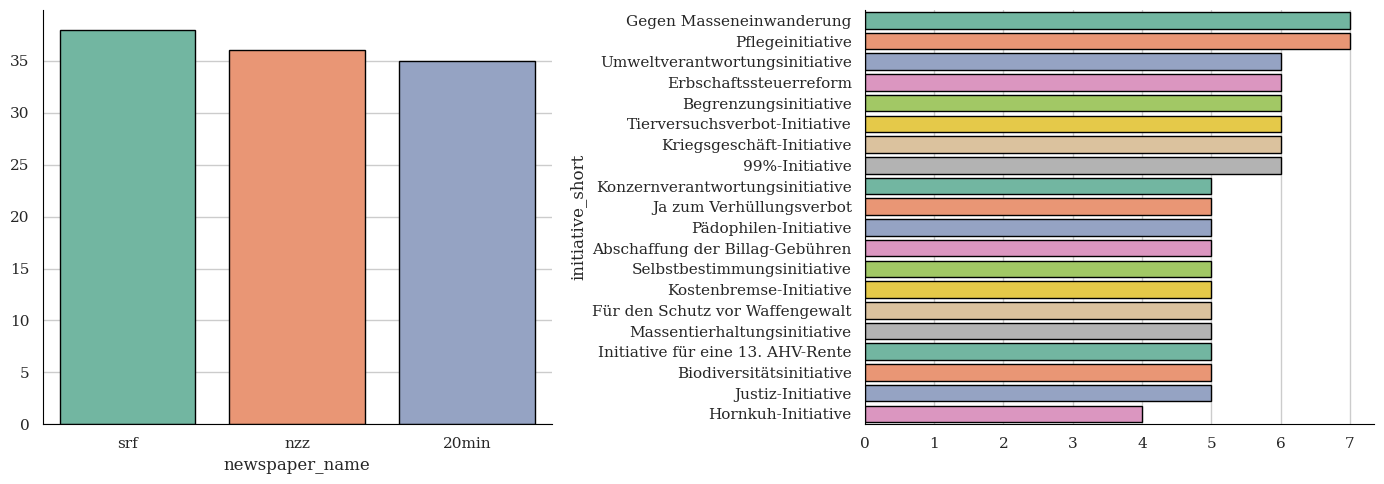

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import re

## for plotting we want consistent short titles for the initiatives
# Manual short titles for long initiative names
manual_shortnames = {
    "Für verantwortungsvolle Unternehmen – zum Schutz von Mensch und Umwelt": "Konzernverantwortungsinitiative",
    "Ja zum Tier- und Menschenversuchsverbot – Ja zu Forschungswegen mit Impulsen für Sicherheit und Fortschritt": "Tierversuchsverbot-Initiative",
    "Pädophile sollen nicht mehr mit Kindern arbeiten dürfen": "Pädophilen-Initiative"
}

# As some already contain short names in brackets, we write a function to extract / assign a short tile from before
def get_short_title(title):
    if not isinstance(title, str):
        return title
    # Falls in Mapping manuell definiert
    if title in manual_shortnames:
        return manual_shortnames[title]
    # Falls etwas in Klammern steht, das extrahieren
    match = re.search(r"\((.*?)\)", title)
    if match:
        return match.group(1)
    # Fallback: Originaltitel
    return title

# Apply short title extraction
df_new["initiative_short"] = df_new["initiative"].apply(get_short_title)

# Plotting style settings
sns.set_theme(style="whitegrid", context="notebook", font="serif")
plt.rcParams.update({
    "axes.edgecolor": "black",
    "axes.linewidth": 0.8,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "font.family": "serif",
})

# Count data for plotting
article_counts = df_new["newspaper_name"].value_counts()
initiative_counts = df_new["initiative_short"].value_counts().sort_values(ascending=False)

# Create two side-by-side bar plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Articles per News Outlet
sns.barplot(
    x=article_counts.index,
    y=article_counts.values,
    hue=article_counts.index,      
    legend=False,                  
    palette="Set2",
    edgecolor="black",
    ax=axes[0]
)

# Plot 2: Articles per Initiative
sns.barplot(
    y=initiative_counts.index,
    x=initiative_counts.values,
    hue=initiative_counts.index,    
    legend=False,
    palette="Set2",
    edgecolor="black",
    ax=axes[1]
)


sns.despine()
plt.tight_layout()
plt.show()



**Interpretation**

The dataset displays a relatively balanced distribution of articles across the three selected Swiss media outlets. SRF and 20 Minuten each contribute close to 38–39 articles, while NZZ provides slightly fewer, with around 36 articles. This near-uniform representation ensures that no single outlet disproportionately shapes the overall media narrative in the sample. As a result, subsequent analyses—such as sentiment or topic modeling—are less likely to be biased by overrepresentation from any one source, which enhances the robustness of the exploratory insights.

To further investigate the distribution of articles, a pivot table was created showing the number of articles per initiative and news outlet. The resulting heatmap reveals that most initiatives are covered by all three outlets, though some variation exists—for example, SRF did not cover the “Für den Schutz vor Waffengewalt” initiative, while 20 Minuten omitted the “Hornkuh-Initiative.” This table helps to identify potential gaps in coverage and confirms that, overall, media attention is fairly evenly spread across the selected initiatives.


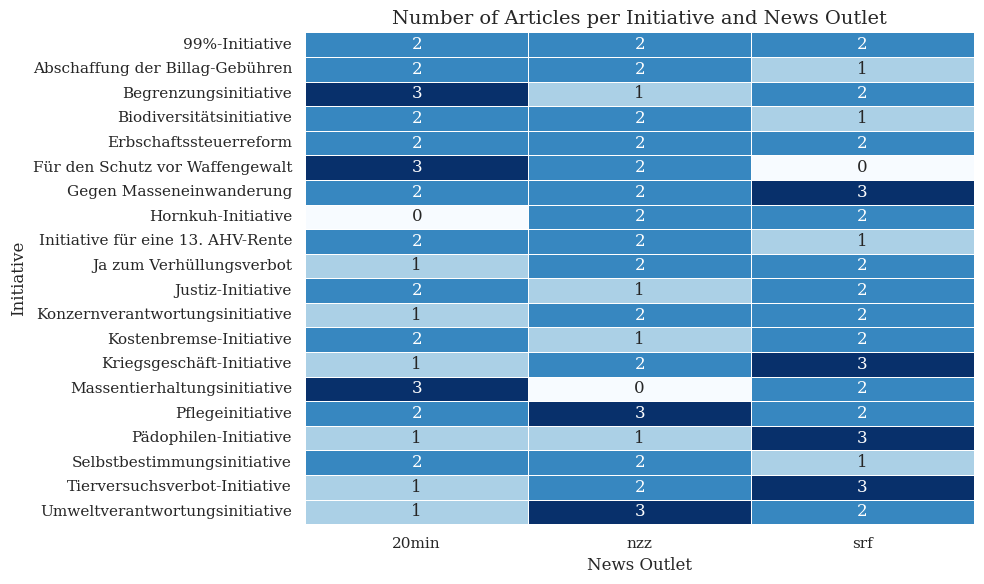

In [ ]:
# Pivot-Table: Numbers of Articles per Initiative and News Outlet
pivot = df_new.pivot_table(index="initiative_short", columns="newspaper_name", aggfunc="size", fill_value=0)

plt.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=True, fmt="d", cmap="Blues", cbar=False, linewidths=0.5)
plt.title("Number of Articles per Initiative and News Outlet")
plt.xlabel("News Outlet")
plt.ylabel("Initiative")
plt.tight_layout()
plt.show()

### 2.2 Distribution of Article Lengths

To gain a better understanding of the informational content of the dataset, we analyze article length as measured by the number of characters per text. While length alone is not a direct indicator of quality or depth, it can serve as a useful proxy for the richness or density of the content presented. Examining these distributions also helps identify whether certain media outlets tend to produce more concise or more elaborated reporting.

The histogram below illustrates the distribution of article lengths across all included news sources.



C:\Users\valen\AppData\Local\Temp\ipykernel_32616\1851276478.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_new, x="newspaper_name", y="text_length", palette="Set2", ax=axes[1])


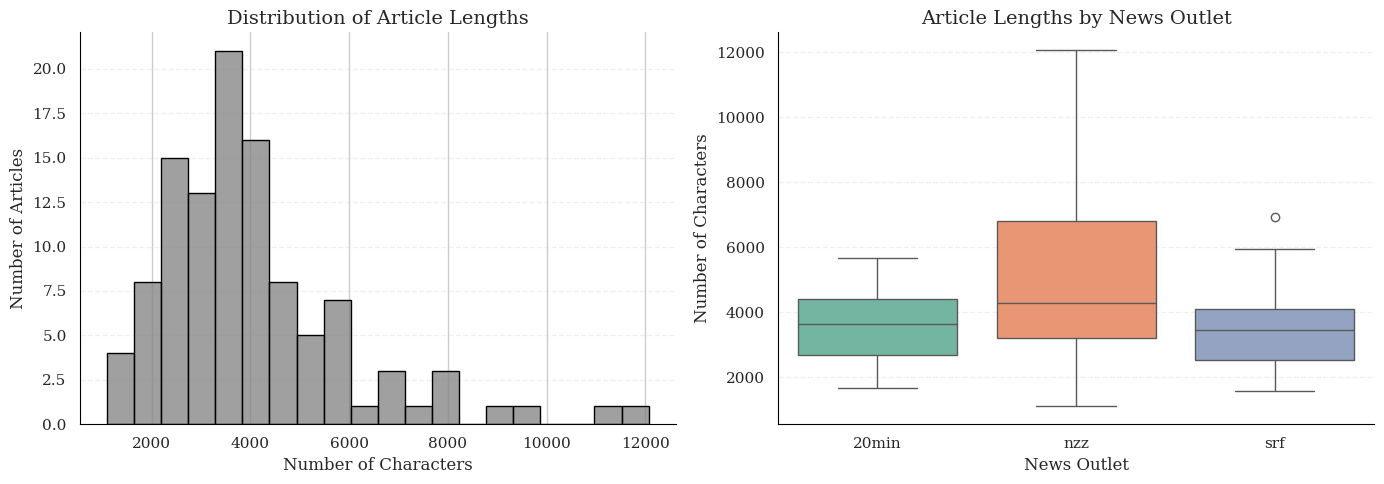

In [ ]:
# text length
df_new["text_length"] = df_new["text"].apply(lambda x: len(x) if isinstance(x, str) else 0)

# Set up subplot layout
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Histogram
sns.histplot(data=df_new, x="text_length", bins=20, kde=False, color="gray", edgecolor="black", ax=axes[0])
axes[0].set_title("Distribution of Article Lengths")
axes[0].set_xlabel("Number of Characters")
axes[0].set_ylabel("Number of Articles")
axes[0].grid(axis="y", linestyle="--", alpha=0.3)

# Plot 2: Boxplot by Outlet
sns.boxplot(data=df_new, x="newspaper_name", y="text_length", palette="Set2", ax=axes[1])
axes[1].set_title("Article Lengths by News Outlet")
axes[1].set_xlabel("News Outlet")
axes[1].set_ylabel("Number of Characters")
axes[1].grid(axis="y", linestyle="--", alpha=0.3)

# Clean up
sns.despine()
plt.tight_layout()
plt.show()



**Interpretation**

The histogram on the left shows the overall distribution of article lengths in the dataset. Most articles range between 2,000 and 5,000 characters, with a few longer texts exceeding 10,000 characters. This right-skewed distribution suggests that while most coverage remains relatively concise, some articles offer more detailed reporting.

The boxplot on the right breaks down article lengths by media outlet. It shows that *NZZ* tends to publish longer articles compared to *20 Minuten* and *SRF*. This is consistent with NZZ’s reputation as a more in-depth and analysis-oriented outlet. The other two sources, especially 20 Minuten, produce more compact texts on average.


### 2.3 Wordclouds by Voting Outcome

To explore whether articles differ in their language depending on the outcome of a vote, we generate two wordclouds: one for initiatives that were accepted and one for those that were rejected. This allows for a visual comparison of the most frequent terms in media coverage, highlighting differences in topic emphasis, tone, or framing across accepted and rejected proposals.

While wordclouds are not precise analytical tools, they provide a useful exploratory perspective. By highlighting the most frequent terms in a large collection of texts, they can offer initial insights into framing tendencies and content focus, serving as a qualitative prelude to more formal NLP methods.

To generate the wordclouds, we apply basic text preprocessing to standardize the input and remove semantically irrelevant words. We load the default German stopword list from `nltk` to extract those words as they carry no meaningful content. 

The result column is cleaned by trimming whitespace and lowercasing, allowing for consistent filtering of accepted versus rejected initiatives. Article texts are then grouped by outcome and concatenated into two lowercase strings.

Using the `WordCloud` class, we generate visualizations for each group based on the 100 most frequent non-stopword terms. The resulting plots provide a comparative overview of lexical patterns in articles linked to accepted versus rejected initiatives.


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Giou1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


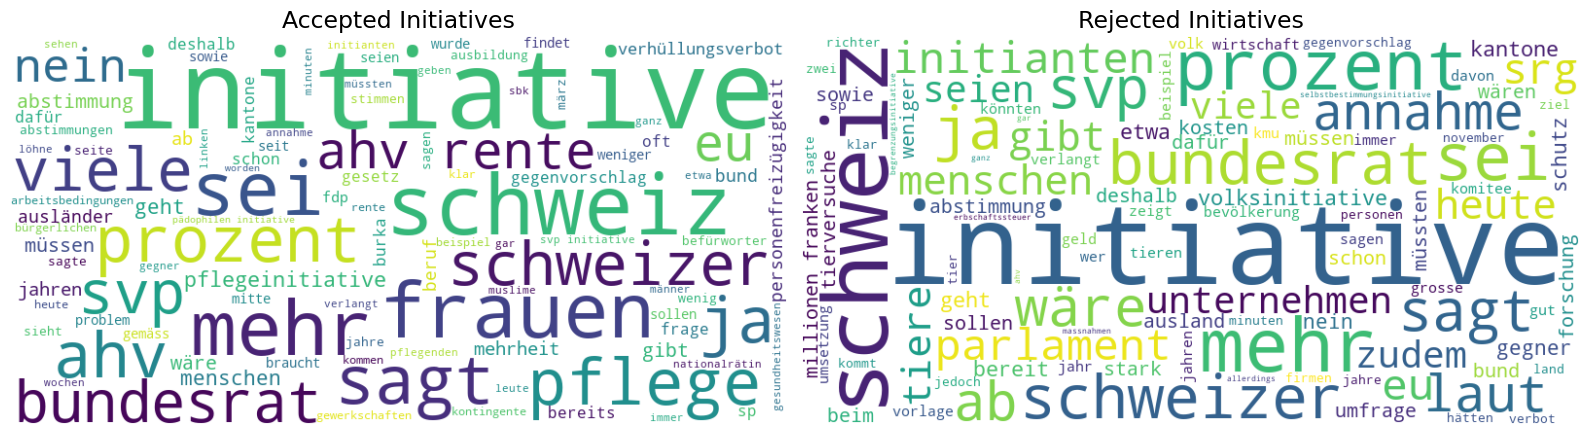

In [20]:
import nltk
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

# load NLTK stopwords
nltk.download("stopwords")

# choose german stopwords
german_stopwords = set(stopwords.words("german"))


# take result
df_new["result_clean"] = df_new["result"].str.strip().str.lower()

# group by result
text_yes = " ".join(df_new[df_new["result_clean"] == "angenommen"]["text"].dropna()).lower()
text_no = " ".join(df_new[df_new["result_clean"] == "abgelehnt"]["text"].dropna()).lower()

# Wordclouds creation 
wc_yes = WordCloud(width=800, height=400, background_color="white",
                   max_words=100, stopwords=german_stopwords).generate(text_yes)

wc_no = WordCloud(width=800, height=400, background_color="white",
                  max_words=100, stopwords=german_stopwords).generate(text_no)

# Plotting the Wordclouds
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].imshow(wc_yes, interpolation="bilinear")
axes[0].axis("off")
axes[0].set_title("Accepted Initiatives", fontsize=17)

axes[1].imshow(wc_no, interpolation="bilinear")
axes[1].axis("off")
axes[1].set_title("Rejected Initiatives", fontsize=17)

plt.tight_layout()
plt.show()



**Interpretation**

The word clouds above provide an overview of the most frequently occurring **words** in news articles related to accepted (*Angenommene*) and rejected (*Abgelehnte*) Swiss initiatives. While some overlap is visible—such as the prominence of general terms like *Initiative*, *Schweiz* (Switzerland), *Bundesrat* (Federal Council), and *Prozent* (percent)—clear thematic differences also emerge.

In articles covering **accepted initiatives**, socially and welfare-oriented terms appear more frequently. Notable examples include:
- *Pflegeinitiative* (nursing initiative),
- *AHV* (state pension insurance),
- *Rente* (pension),
- *Frauen* (women),
- *Arbeitsbedingungen*, *Personenfreizügigkeit* (working conditions),
- *Beruf* (job)

These terms suggest a focus on social protection, care-related reforms, and gender equality.

In contrast, **rejected initiatives** are more associated with political and economic vocabulary:
- *Unternehmen* (companies),
- *Tierversuche* (animal testing),
- *EU*, *Wirtschaft* (economy),
- *Parlament* (parliament),
- *Initianten* (initiators)

This pattern may imply that proposals involving controversial topics, regulatory shifts, or international relations face more public resistance.

Additionally, articles related to rejected initiatives often contain more speculative or indirect language—e.g., *wäre* (would be), *könnte* (could), or *laut* (according to)—indicating a more uncertain or tentative tone.

Overall, the word clouds visually hint at a potential trend: initiatives with concrete social benefits are more likely to be accepted, while those concerning broader systemic changes or contested domains tend to be rejected.


```markdown
### Word Cloud Generation: Unique Words per Outcome and Topic

For the next step, we will create word clouds with a twist: for both accepted and rejected initiatives, and for each topic separately, we will focus only on terms that are unique to one outcome (or topic). In other words, we want to visualize words that do not appear in both groups, highlighting the distinct vocabulary.

The procedure is as follows:

1. **Preprocessing:**  
    • Standardize texts by converting to lowercase and removing punctuation and stopwords.  
    • Separate the articles by their outcome (accepted vs. non accepted) and by predicted topic.

2. **Identifying Unique Words:**  
    • For accepted and rejected initiatives:  
      - Create two sets of words from the texts.  
      - Compute the difference (i.e., words in accepted that are not in rejected, and vice versa).  
    • For each topic:  
      - Repeat the same process on texts belonging to a specific topic, identifying words that are exclusive to that topic within each outcome group.

3. **Word Cloud Creation:**  
    • Use the unique word sets as input to the `WordCloud` generation (from the `wordcloud` package).  
    • Generate and display separate visualizations for accepted initiatives, non accepted initiatives, and for each topic as needed.

This approach will help in understanding the distinctive language use in each category and topic, offering deeper insight into the framing differences across outcomes.
```

### 2.4 Zero-Shot Topic Classification using a Pre-trained Multilingual BART Model

In this section, we aim to understand the thematic focus of media coverage across different initiatives. Specifically, we examine whether certain **topics** appear more frequently in news articles discussing **accepted** versus **rejected** initiatives.

Given the **limited size of our dataset** (~109 articles), traditional topic modeling techniques like LDA or clustering would likely perform poorly and result in noisy, uninterpretable outputs. To address this, we apply a more suitable and robust alternative: **zero-shot topic classification** using a pre-trained transformer model.

We use the `facebook/bart-large-mnli` model provided by HuggingFace, a powerful **multilingual model** trained on Natural Language Inference (NLI). It can determine whether a given text semantically fits into a label, even without prior exposure to the label during training — hence the term *zero-shot*.

What makes this method particularly advantageous for our case:
- **No training required**: The model can classify unseen text into custom-defined categories.
- **Multilingual support**: Despite being trained primarily in English, the model performs well on German texts due to its robust multilingual architecture.
- **Custom labels**: We can define our own relevant policy labels, such as "Wirtschaft" (economy), "Umwelt" (environment), "Migration", and "Sicherheit" (security).

Technically, the model receives a news article and a set of candidate labels. It returns a **score between 0 and 1** for each label, indicating how well the article matches the theme. We apply this to all articles and then aggregate the results by **initiative outcome** (accepted vs. rejected).

This approach provides a much **cleaner and more interpretable topic perspective** than unsupervised models — making it ideal for our small dataset.


In [ ]:
# Import and install the required libraries for Zero-Shot Classification
#%pip install transformers sentencepiece protobuf==3.20.*
from transformers import pipeline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Initialize the Zero-Shot Classification pipeline
# This model is based on BART and is suitable for zero-shot classification tasks
classifier = pipeline(
    "zero-shot-classification",
    model="facebook/bart-large-mnli" 
)

# we choose certain candidate labels for the classification task
candidate_labels = [
    "Wirtschaft", "Umwelt", "Migration", "Gesundheit", 
    "Sicherheit", "Soziales", "Bildung", "Steuern"
]

# Apply the classifier to the text data
# For each article, classify the most relevant topic (Top-1 label) and score
def classify_topic_with_score(text, classifier, labels):
    if not isinstance(text, str) or len(text) < 30:
        return None, None
    try:
        result = classifier(text, labels, multi_label=True)
        top_label = result["labels"][0]
        top_score = result["scores"][0]
        return top_label, top_score
    except:
        return None, None


# Apply classification and store results in new columns
tqdm.pandas()
df_new[["top_topic", "topic_score"]] = df_new["text"].progress_apply(
    lambda x: pd.Series(classify_topic_with_score(x, classifier, candidate_labels))
)


Device set to use cpu
100%|██████████| 109/109 [54:44<00:00, 30.13s/it]


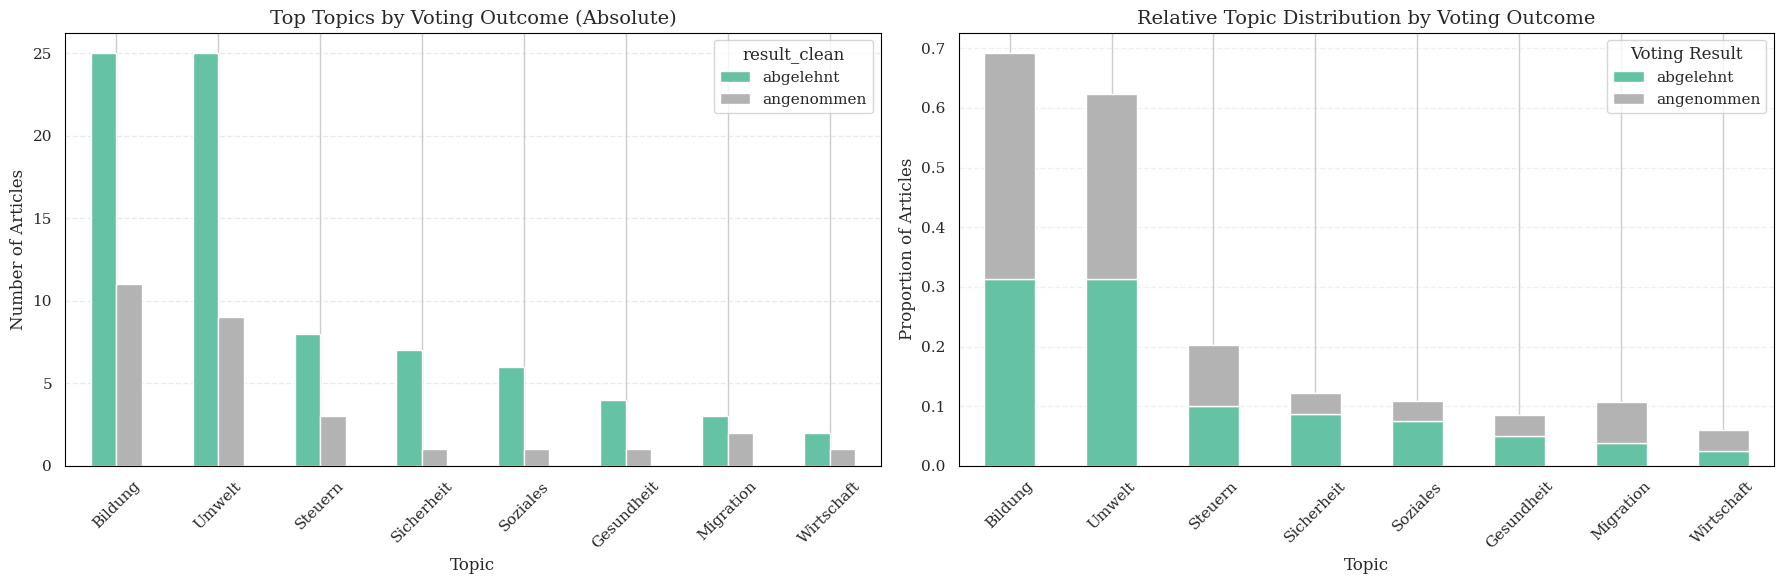

In [ ]:
## First Plot: Absolute and Proportional Topic Counts by Voting Outcome
# Prepare absolute counts
topic_counts = df_new.groupby("result_clean")["top_topic"].value_counts().unstack().fillna(0)
topic_counts = topic_counts[topic_counts.sum().sort_values(ascending=False).index]

# Prepare proportions (row-wise normalization)
topic_props = topic_counts.div(topic_counts.sum(axis=1), axis=0)

# Set up subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=False)

# Plot 1: Absolute topic counts
topic_counts.T.plot(kind="bar", colormap="Set2", ax=axes[0])
axes[0].set_title("Top Topics by Voting Outcome (Absolute)")
axes[0].set_ylabel("Number of Articles")
axes[0].set_xlabel("Topic")
axes[0].tick_params(axis='x', rotation=45)
axes[1].legend(title="Voting Result", loc="upper right")
axes[0].grid(axis="y", linestyle="--", alpha=0.4)

# Plot 2: Proportional topic shares
topic_props.T.plot(kind="bar", stacked=True, colormap="Set2", ax=axes[1])
axes[1].set_title("Relative Topic Distribution by Voting Outcome")
axes[1].set_ylabel("Proportion of Articles")
axes[1].set_xlabel("Topic")
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(title="Voting Result", loc="upper right")
axes[1].grid(axis="y", linestyle="--", alpha=0.3)

# Final layout adjustments
plt.tight_layout()
plt.show()


**Interpretation**

Education, environment, and taxation emerge as the most frequently covered topics in media reporting on federal initiatives, highlighting their central role in Swiss political discourse. The distribution of topics indicates that initiatives related to "Bildung" (Education) and "Migration" are more frequently associated with accepted outcomes, whereas topics such as "Umwelt" (Environment), "Sicherheit" (Security), and "Soziales" (Social Policy) are more often linked to rejected initiatives. This is visible both in absolute and relative terms. "Wirtschaft" (Economy) also shows a higher share of accepted initiatives, though with fewer total articles.

While this pattern may hint at topic-related differences in public approval, caution is needed. First, topic classification was automated using zero-shot learning and may involve classification noise. Second, the dataset is small and unevenly distributed across vote outcomes and topics, limiting statistical inference. Lastly, the assigned topics reflect general themes but do not capture the **stance or framing** of the article — for example, whether "Wirtschaft" refers to economic benefits, criticisms, or consequences of the initiative in question.


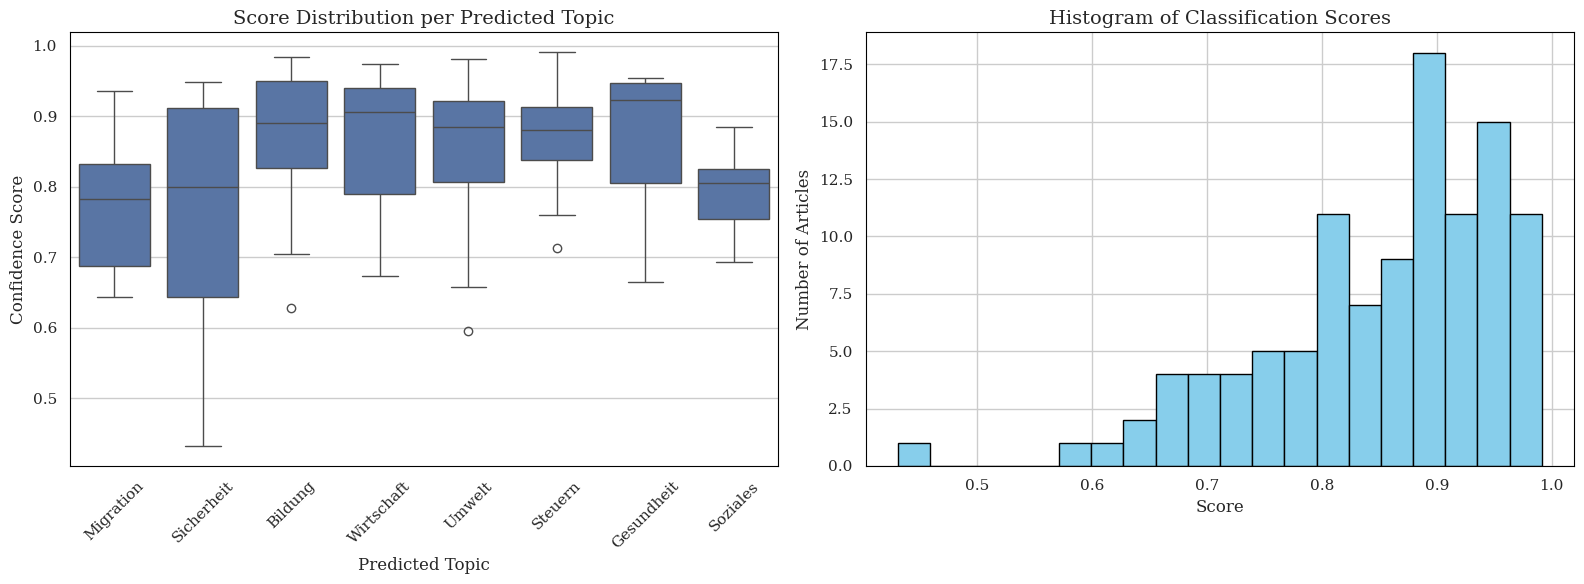

In [ ]:
## Second Plot: Visualize the distribution of classification scores
# Set up subplots: 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Boxplot: Score distribution by topic
sns.boxplot(data=df_new, x="top_topic", y="topic_score", ax=axes[0])
axes[0].set_title("Score Distribution per Predicted Topic")
axes[0].set_xlabel("Predicted Topic")
axes[0].set_ylabel("Confidence Score")
axes[0].tick_params(axis='x', rotation=45)

# Histogram: Overall score distribution
axes[1].hist(df_new["topic_score"].dropna(), bins=20, color='skyblue', edgecolor='black')
axes[1].set_title("Histogram of Classification Scores")
axes[1].set_xlabel("Score")
axes[1].set_ylabel("Number of Articles")

plt.tight_layout()
plt.show()


**Interpretation**

The *classification scores* represent the model's confidence in assigning a given topic to each article. As shown, most predictions lie above 0.8, suggesting high confidence across topics. Topics such as "Bildung", "Gesundheit", and "Wirtschaft" exhibit particularly tight score distributions, while "Sicherheit" and "Migration" show more variation and lower median confidence.

However, high classification scores do not imply semantic correctness. The scores reflect how well a topic fits relative to other candidate labels, not whether the assigned topic truly captures the article’s core issue. Manual review revealed that topic assignments were generally accurate, but the category "Bildung" (Education) was frequently over-assigned. This likely inflates its prominence and limits the interpretability of topic-specific patterns.


## 3. Data Modelling




### 3.1 Sentiment Analysis

In this section, we perform sentiment classification on the article texts using a transformer-based language model specifically fine-tuned for German sentiment detection (`oliverguhr/german-sentiment-bert`). The model outputs a categorical label (`positive`, `neutral`, or `negative`) along with a confidence score for each prediction.

We apply the model to each article by feeding the text directly into the pipeline. Since transformer models have a maximum input length of 512 tokens (typically around 4000–5000 characters for German text), we truncate longer articles to this limit. As shown in the previous figure, the majority of articles fall within this range: over 80% of texts are shorter than 5000 characters and thus remain unaffected by this constraint. Only a small number of outliers—very long articles—will be partially truncated. This trade-off allows efficient processing while preserving most of the sentiment-relevant content.

The predicted sentiment labels are then mapped to numeric values (`+1` for positive, `0` for neutral, and `–1` for negative) to enable comparative analysis across outcome groups (`accepted` vs. `rejected`). We additionally record the model’s confidence score, which serves as a proxy for classification certainty.

This setup enables us to explore whether articles covering accepted initiatives tend to be more positively framed than those covering rejected ones—offering a first empirical test of media alignment with public vote outcomes.


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline


# load the sentiment analysis model and tokenizer
# This model is a German BERT model fine-tuned for sentiment analysis
model_name = "oliverguhr/german-sentiment-bert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# estimate sentiment for each article and store results in new columns
# Define a function to get sentiment label and score
def get_sentiment_info(text):
    result = sentiment_pipeline(text[:512])[0]  # reduction of max length to 512 tokens
    return pd.Series([result["label"], result["score"]])

df_new[["sentiment_label", "sentiment_score"]] = df_new["text"].apply(get_sentiment_info)

# add a numerical value for the sentiment label
label_map = {"positive": 1, "neutral": 0, "negative": -1}
df_new["sentiment_value"] = df_new["sentiment_label"].map(label_map)

c:\Users\valen\anaconda3\envs\ml_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Device set to use cpu


In [ ]:
# Count sentiment labels
sentiment_counts = df_new["sentiment_label"].value_counts().rename_axis("sentiment").reset_index(name="count")

# Display as table
print(sentiment_counts)

  sentiment  count
0   neutral     94
1  negative     15


**Interpretation**

Due to the formal and objective tone of journalistic writing, the sentiment model classified the vast majority of articles as neutral (94 out of 109), with only a small number labeled as negative (15) and none as positive. This outcome reflects both the nature of political reporting and the limitations of sentiment models trained on more subjective or emotionally charged texts. As a result, variation in sentiment is minimal, and further statistical analysis based on sentiment values is not meaningful in this context.


### 3.2 Stance Detection

The previous sentiment analysis showed that the majority of articles were classified as **neutral**, which is unsurprising given the formal tone and stylistic conventions of journalistic writing. However, this also implies that **standard sentiment models** are not well suited to capture subtle argumentative cues or policy positions in political texts.

To address this limitation, we implement a **stance detection approach**, where texts are manually annotated into three discrete categories: `pro`, `neutral`, and `contra`. This allows us to move beyond emotional tone and instead focus on the **directional alignment of a text** toward the respective voting proposal.

We fine-tune a pre-trained **BERT-based transformer model** (German) on our manually labeled dataset using HuggingFace’s `Trainer` API. The model is trained as a multiclass classifier to predict stance labels from full-text newspaper articles.


#### 3.2.1 Data Preparation



We randomly select 40 articles that then are manually labeled into pro, neutral and contra, which then is used for training purposes. 

In [ ]:
# coosen a sample size for each voting outcome
# We want to sample 40 articles for each voting outcome (20 for "yes" and 20 for "no")
sample_size = 40
sampled_df = df_new.groupby("result_clean").apply(lambda x: x.sample(sample_size // 2, random_state=42)).reset_index(drop=True)

# export dataset for manual classification
sampled_df[["id", "text", "result_clean"]].to_excel("stance_sample.xlsx", index=False)




C:\Users\valen\AppData\Local\Temp\ipykernel_32616\358472856.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df_new.groupby("result_clean").apply(lambda x: x.sample(sample_size // 2, random_state=42)).reset_index(drop=True)


In [ ]:
# Load manually labeled Excel file
df_labeled = pd.read_excel("stance_sample_labeled.xlsx")

# Standardize the label (lowercase everything, as some errors were made)
df_labeled["own_sentiment"] = df_labeled["own_sentiment"].str.lower().str.strip()

# enforce allowed categories (to catch typos)
valid_labels = {"pro", "neutral", "contra"}
df_labeled = df_labeled[df_labeled["own_sentiment"].isin(valid_labels)]

# Merge with original DataFrame via 'id'
df_new = df_new.merge(df_labeled[["id", "own_sentiment"]], on="id", how="left")

# Step 4 (optional): Check distribution
print(df_new["own_sentiment"].value_counts(dropna=False))



own_sentiment
NaN        69
neutral    20
contra     12
pro         8
Name: count, dtype: int64


Out of the 40 manually labeled articles, 20 were classified as neutral, 12 as contra, and 8 as pro. This distribution reflects the often non-explicit and balanced tone of political journalism. Compared to the earlier sentiment analysis, which labeled over 85% of texts as neutral, manual stance coding captures more nuanced positions not detectable through generic sentiment models. Although the class imbalance limits predictive performance for minority classes (especially pro), the manual annotations provide a more targeted and context-aware basis for supervised stance classification.

#### 3.2.2 Prepare the pre-labeled data

Extract the 40 articles that were manually labeled before und prepare for modeltraining. 

In [ ]:
#%pip install datasets
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict

# Filter labeled data
df_labeled = df_new[df_new["own_sentiment"].notna()].copy()
label_map = {"pro": 0, "neutral": 1, "contra": 2}
df_labeled["stance_label"] = df_labeled["own_sentiment"].str.lower().map(label_map)
df_labeled["text_input"] = df_labeled["text"]

# Stratified split
train_df, test_df = train_test_split(
    df_labeled[["text_input", "stance_label"]],
    test_size=0.2,
    random_state=42,
    stratify=df_labeled["stance_label"]
)

# Convert to HF DatasetDict
dataset = DatasetDict({
    "train": Dataset.from_pandas(train_df.reset_index(drop=True)),
    "test": Dataset.from_pandas(test_df.reset_index(drop=True))
})


#### 3.2.3 Load the tokenizer and model

We use a pre-trained german BERT-Model as Base and erweitern es um unsere Klassifikation. BERT is highly good fit as it understands Syntax, Context and wordmeaning durch bidirektionales Training ?? WAS

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "bert-base-german-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3) # num_labels=3 for pro, neutral, contra


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### 3.2.4 Tokenize the input text

BERT requires tokenized input (Words in number format). We herby reduce on 512 Tokens (BERT-Limit), padding sorgt dafür, dass alle Sequenzen gleich lang sind.. BERT (as all Transformer-Modells) do not require to lowercase, lemmatisieren und stopword entfernen (--> Tokenizer uses Language kontextbasiert, nicht als Bag-of_words)

In [ ]:
def tokenize_function(example):
    return tokenizer(example["text_input"], truncation=True, padding="max_length", max_length=512)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.rename_column("stance_label", "labels")



Map: 100%|██████████| 8/8 [00:00<00:00, 333.75 examples/s]


#### 3.2.5 Define training setup and run training

Wir konfigurieren den Trainingsprozess, wählen Optimierungsparameter and lassen das Modell lernen

In [ ]:

#%pip install -U "transformers[torch]" "accelerate>=0.26.0" evaluate transformers
import numpy as np
import evaluate
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments

# Load evaluation metrics
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

# Define evaluation logic
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "f1_macro": f1.compute(predictions=preds, references=labels, average="macro")["f1"]
    }

# Define training configuration
training_args = TrainingArguments(
    output_dir="./stance_model",
    eval_strategy="epoch",
    logging_dir="./logs",
    num_train_epochs=5,
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    weight_decay=0.01
)

# Launch training
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()


C:\Users\valen\AppData\Local\Temp\ipykernel_32616\3628940257.py:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
c:\Users\valen\anaconda3\envs\ml_env\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,0.992624,0.500000,0.222222
2,No log,0.962493,0.500000,0.242424
3,No log,0.968008,0.500000,0.222222
4,No log,0.987182,0.500000,0.222222
5,No log,0.956431,0.500000,0.222222


c:\Users\valen\anaconda3\envs\ml_env\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\valen\anaconda3\envs\ml_env\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\valen\anaconda3\envs\ml_env\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\valen\anaconda3\envs\ml_env\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\valen\anaconda3\envs\ml_env\lib\site-packag

TrainOutput(global_step=40, training_loss=0.8110114097595215, metrics={'train_runtime': 382.2411, 'train_samples_per_second': 0.419, 'train_steps_per_second': 0.105, 'total_flos': 42098146836480.0, 'train_loss': 0.8110114097595215, 'epoch': 5.0})

**Interpretation**

The fine-tuned BERT model was trained on the manually labeled stance dataset for five epochs.  
As shown below, the performance metrics indicate that the model fails to differentiate effectively between the three stance categories (`pro`, `neutral`, `contra`):

- **Accuracy** remains constant at 0.50 throughout most epochs.
- **F1 Macro** fluctuates between 0.22 and 0.24, clearly below the random baseline of 0.33 expected for a uniform 3-class prediction problem.
- **Validation loss** does not show systematic improvement across epochs, further indicating a lack of learning signal.

This result suggests that the model converges toward predicting the majority class (`neutral`) without capturing class-specific patterns.

Given the **small and imbalanced dataset**, this behavior is expected. To address this issue and compensate for underrepresented classes (`pro`, `contra`), we apply a **weighted loss function** in the next step.

In [ ]:
#%pip install -U "transformers[torch]" "accelerate>=0.26.0" evaluate

import numpy as np
import evaluate
import torch
from sklearn.utils.class_weight import compute_class_weight
from torch import nn
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)


# 1. Load evaluation metrics
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "f1_macro": f1.compute(predictions=preds, references=labels, average="macro")["f1"]
    }


# 2. Compute class weights
labels = tokenized_datasets["train"]["labels"]
class_weights = compute_class_weight("balanced", classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float)
print("Class weights:", class_weights)

# 3. Define custom weighted model
class WeightedBERT(nn.Module):
    def __init__(self, base_model_name, num_labels, class_weights):
        super().__init__()
        self.model = AutoModelForSequenceClassification.from_pretrained(base_model_name, num_labels=num_labels)
        self.loss_fn = nn.CrossEntropyLoss(weight=class_weights)

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, labels=None):
        outputs = self.model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            labels=None
        )
        logits = outputs.logits
        loss = self.loss_fn(logits, labels) if labels is not None else None
        return {"loss": loss, "logits": logits}

# Instantiate model
base_model_name = "bert-base-german-cased"
model = WeightedBERT(base_model_name, num_labels=3, class_weights=class_weights)


# 4. Training arguments
training_args = TrainingArguments(
    output_dir="./stance_model",
    eval_strategy="epoch",
    logging_dir="./logs",
    num_train_epochs=5,
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    weight_decay=0.01
)


# 5. Launch training
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()


Class weights: tensor([1.7778, 0.6667, 1.0667])


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\valen\AppData\Local\Temp\ipykernel_32616\1919014919.py:78: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
c:\Users\valen\anaconda3\envs\ml_env\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,1.095629,0.500000,0.222222
2,No log,1.057861,0.250000,0.133333
3,No log,1.047448,0.375000,0.200000
4,No log,1.057196,0.500000,0.222222
5,No log,1.045084,0.500000,0.222222


c:\Users\valen\anaconda3\envs\ml_env\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\valen\anaconda3\envs\ml_env\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\valen\anaconda3\envs\ml_env\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\valen\anaconda3\envs\ml_env\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\valen\anaconda3\envs\ml_env\lib\site-packag

TrainOutput(global_step=40, training_loss=0.904964542388916, metrics={'train_runtime': 379.2071, 'train_samples_per_second': 0.422, 'train_steps_per_second': 0.105, 'total_flos': 0.0, 'train_loss': 0.904964542388916, 'epoch': 5.0})

Despite this adjustment, the model did not show meaningful performance improvements:

- **F1 Macro** remained below 0.25 across all epochs, slightly worse than the unweighted model.
- **Accuracy** fluctuated between 0.25 and 0.50, with no consistent upward trend.
- **Validation loss** showed no stable decline, indicating limited learning dynamics.

This outcome suggests that class weighting alone is insufficient to improve classification performance in this context.  
The dataset size and structural similarity between stance categories likely constrain the model’s ability to generalize.

In [ ]:
# Predictions on test set
predictions = trainer.predict(tokenized_datasets["test"])
predicted_labels = np.argmax(predictions.predictions, axis=1)

# Mapping to text labels
id2label = {0: "pro", 1: "neutral", 2: "contra"}
predicted_text_labels = [id2label[i] for i in predicted_labels]

# DataFrame
import pandas as pd
df_test = pd.DataFrame({
    "true_label": tokenized_datasets["test"]["labels"],
    "predicted_label": predicted_labels,
    "predicted_text": predicted_text_labels
})




c:\Users\valen\anaconda3\envs\ml_env\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


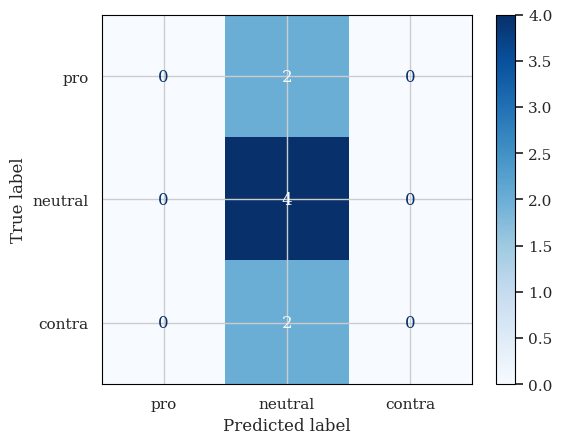

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# confusion matrix
cm = confusion_matrix(df_test["true_label"], df_test["predicted_label"])
disp = ConfusionMatrixDisplay(cm, display_labels=["pro", "neutral", "contra"])
disp.plot(cmap="Blues")
plt.show()


### 3.2 ML

In [ ]:
import os

# Pfad zum Projektordner
repo_path = "C:/Users/valen/OneDrive/Desktop/ml_project/Media-Language"

# Alle Dateien durchsuchen und sortieren nach Größe
file_sizes = []
for root, dirs, files in os.walk(repo_path):
    for file in files:
        path = os.path.join(root, file)
        try:
            size = os.path.getsize(path)
            file_sizes.append((size, path))
        except:
            continue

# Top 10 größte Dateien anzeigen
for size, path in sorted(file_sizes, reverse=True)[:10]:
    print(f"{size/1024/1024:.2f} MB\t{path}")


832.40 MB	C:/Users/valen/OneDrive/Desktop/ml_project/Media-Language\stance_model\checkpoint-40\optimizer.pt
623.67 MB	C:/Users/valen/OneDrive/Desktop/ml_project/Media-Language\.git\objects\81\1599de8078e6bb2c47754a91d7eabd12294f1f
416.14 MB	C:/Users/valen/OneDrive/Desktop/ml_project/Media-Language\stance_model\checkpoint-40\model.safetensors
387.58 MB	C:/Users/valen/OneDrive/Desktop/ml_project/Media-Language\.git\objects\97\f45cb22f2075587e2751efbfd2d04c2de52e1a
1.45 MB	C:/Users/valen/OneDrive/Desktop/ml_project/Media-Language\Jupyter_Code.ipynb
0.97 MB	C:/Users/valen/OneDrive/Desktop/ml_project/Media-Language\.git\objects\6d\3d454eadac0af8f442207bc1d42a2d891afc6b
0.92 MB	C:/Users/valen/OneDrive/Desktop/ml_project/Media-Language\.git\objects\41\b5169926363792821430865657cb4ebea0f129
0.92 MB	C:/Users/valen/OneDrive/Desktop/ml_project/Media-Language\.git\objects\4e\757d85b73199e32ab913ce910043ee88a56833
0.92 MB	C:/Users/valen/OneDrive/Desktop/ml_project/Media-Language\.git\objects\be\a07